In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/

In [ ]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(  # Mean and std for each channel
        mean=[0.4914, 0.4822, 0.4465], #
        std=[0.2023, 0.1994, 0.2010],  #
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,                # <- that's slick. Normalized directly.
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset       
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)                  #  This is cool. The set definition is done right in here.
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [ ]:
# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)     # Note, these are both conv2d
        out = self.conv2(out)   #
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):  
    def _make_layer(self, 
                    block, # this is the residual block class
                    planes,
                    blocks, 
                    stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
num_classes = 10
num_epochs = 2#0
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/2], Loss: 1.0709
Accuracy of the network on the 5000 validation images: 58.72 %
Epoch [2/2], Loss: 0.6718
Accuracy of the network on the 5000 validation images: 72.6 %


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 72.53 %


In [ ]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

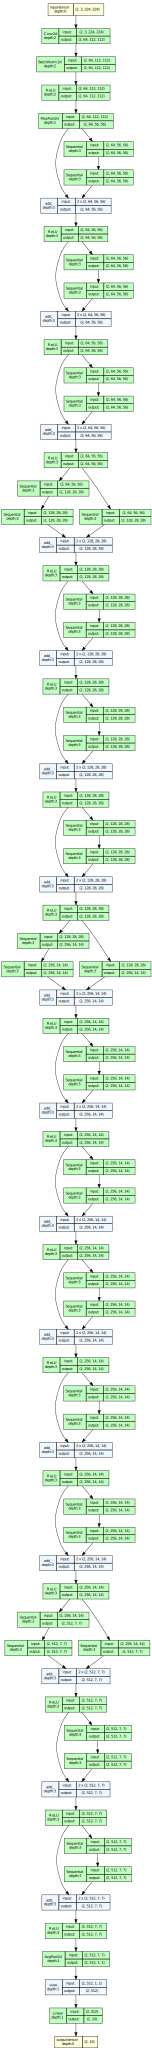

In [ ]:
from torchview import draw_graph

batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, 3, 224, 224), device='meta')
model_graph.visual_graph